In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import os
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img_size = (512, 512)

content_path = '/content/drive/MyDrive/Colab Notebooks/Images/Alma Mater.jpg'
content_img = tf.io.read_file(content_path)
content_img = tf.image.decode_image(content_img, channels=3)
content_img = tf.image.convert_image_dtype(content_img, tf.float32)
content_img = tf.image.resize(content_img, img_size)

style_path = '/content/drive/MyDrive/Colab Notebooks/Images/Mondrian.jpg'
style_img = tf.io.read_file(style_path)
style_img = tf.image.decode_image(style_img, channels=3)
style_img = tf.image.convert_image_dtype(style_img, tf.float32)
style_img = tf.image.resize(style_img, img_size)

preprocessed_content = tf.keras.applications.vgg19.preprocess_input(content_img*255)
preprocessed_style = tf.keras.applications.vgg19.preprocess_input(style_img*255)

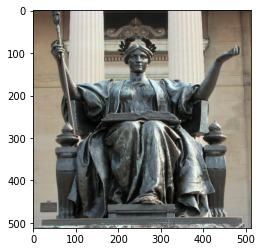

In [ ]:
plt.imshow(content_img.numpy())

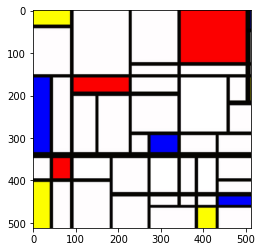

In [ ]:
plt.imshow(style_img.numpy())

In [ ]:
def loss_function(preprocessed_content, preprocessed_style, target_img, alpha=1e-2, beta=1e-2):
  
  content_layers = ['block5_conv2'] 
  style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

  vgg19 = tf.keras.applications.VGG19(include_top=False)
  vgg19.trainable = False
  content_model = tf.keras.Model([vgg19.input], [vgg19.get_layer(layer).output for layer in content_layers])
  style_model = tf.keras.Model([vgg19.input], [vgg19.get_layer(layer).output for layer in style_layers])

  preprocessed_target = tf.keras.applications.vgg19.preprocess_input(target_img*255)
  
  content_features = content_model(tf.expand_dims(preprocessed_content, axis=0))
  target_content_features = content_model(tf.expand_dims(preprocessed_target, axis=0))

  style_features = style_model(tf.expand_dims(preprocessed_style, axis=0))
  target_style_features = style_model(tf.expand_dims(preprocessed_target, axis=0))

  content_loss = tf.math.reduce_mean(tf.math.square(target_content_features - content_features))

  E = []
  for l in range(len(style_features)):
    N = style_features[l].shape[-1]
    M = tf.math.reduce_prod(style_features[l].shape[:-1]).numpy()
    style_features_reshaped = tf.reshape(style_features[l], [M, N])
    A = tf.matmul(style_features_reshaped, style_features_reshaped, transpose_a=True)
    target_style_features_reshaped = tf.reshape(target_style_features[l], [M, N])
    G = tf.matmul(target_style_features_reshaped, target_style_features_reshaped, transpose_a=True)
    E.append(tf.math.reduce_mean(tf.math.square(G - A)))
  style_loss = sum(E) / len(E)

  total_loss = alpha * content_loss + beta * style_loss
  return total_loss

In [ ]:
tf.random.set_seed(0)
#target_img = tf.Variable(tf.random.uniform(tf.concat([img_size, [3]], 0)))
target_img = tf.Variable(content_img)
#target_img = tf.Variable(style_img)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.1)
steps = 100
alpha = 1
beta = 1e-14

losses = []

for i in range(steps):
  if i%10==0:
    print(i)
  with tf.GradientTape() as tape:
    loss = loss_function(preprocessed_content, preprocessed_style, target_img, alpha, beta)
  losses.append(loss)
  grad = tape.gradient(loss, target_img)
  opt.apply_gradients([(grad, target_img)])
  target_img.assign(tf.clip_by_value(target_img, 0.0, 1.0))
losses.append(loss_function(preprocessed_content, preprocessed_style, target_img, alpha, beta))

0
10
20
30
40
50
60
70
80
90


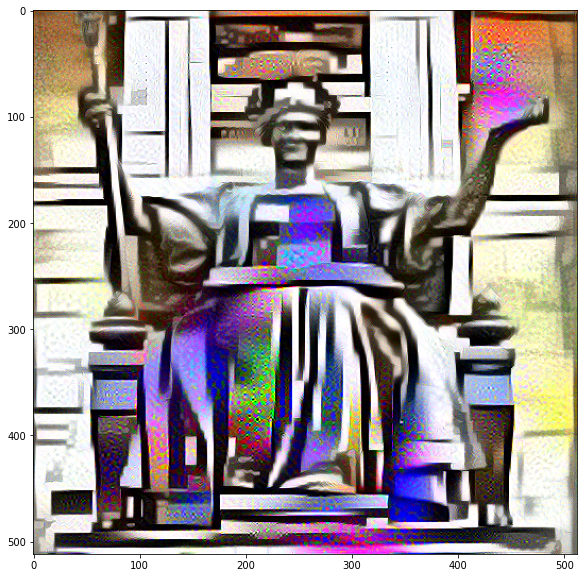

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(target_img.numpy())

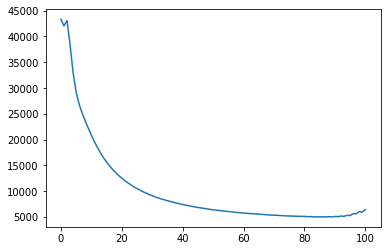

In [ ]:
plt.plot(losses)